In [1]:
from AudioDataLoading import DataLoad

# Remove './Data/genres_original/jazz/jazz.00054.wav' from the data folder as this file is broken and it will crash the loader
data_path = "./Data/genres_original"
data_loader = DataLoad(data_path)
X, y = data_loader.fetch_dataset()

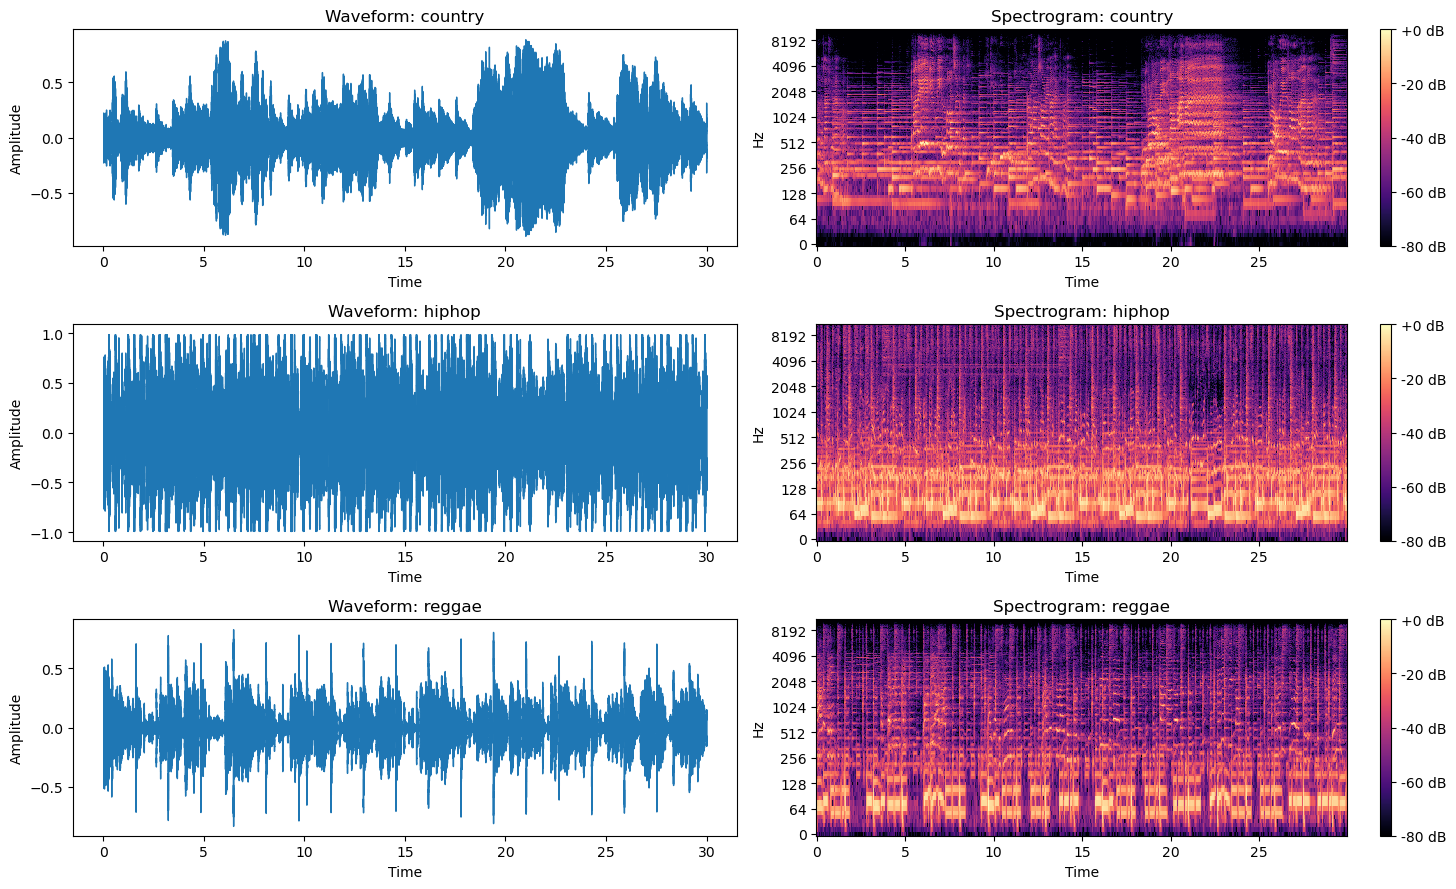

In [5]:
import matplotlib.pyplot as plt
import random
import librosa.display
import numpy as np

def show_samples(X, y, genre_names, n_samples=5, sr=22050):
    indices = random.sample(range(len(X)), n_samples)
    samples = X[indices]
    labels = y[indices]
    
    plt.figure(figsize=(15, 3 * n_samples))  # Adjust height based on number of samples
    
    for i, (audio, label_idx) in enumerate(zip(samples, labels)):
        # Create subplot for waveform
        plt.subplot(n_samples, 2, i*2 + 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform: {genre_names[label_idx]}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        
        # Create subplot for spectrogram
        plt.subplot(n_samples, 2, i*2 + 2)
        S = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        librosa.display.specshow(S, sr=sr, y_axis='log', x_axis='time')
        plt.title(f"Spectrogram: {genre_names[label_idx]}")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

show_samples(X, y, data_loader.get_genre_names(), n_samples=3, sr=22050)

In [23]:
# print(len(y))
X.shape

(999, 661500)

In [1]:
import torch
from AudioEncoderArch import AudioEncoder
encoder = AudioEncoder(latent_dim=128, input_length=661500) 
sample_input = torch.randn(1, 1, 661500)  # (batch, channels, length)
    
mean, logvar, latent_encoding = encoder(sample_input)
print("Mean Shape:", mean.shape)
print("Log Variance Shape:", logvar.shape)
print("Latent Encoding Shape:", latent_encoding.shape)

Mean Shape: torch.Size([1, 128])
Log Variance Shape: torch.Size([1, 128])
Latent Encoding Shape: torch.Size([1, 128])


In [5]:
from AudioDecoderArch import AudioDecoder
decoder = AudioDecoder(latent_dim=128, output_length=661500)
latent_vector = torch.randn(1, 128)  
output_audio = decoder(latent_vector)
print(f"Decoder output shape: {output_audio.shape}")

Decoder output shape: torch.Size([1, 1, 661500])


In [ ]:
## You can also run using terminal -> python3 audio_train.py OR run the chunk
## Memory usage is huge

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from AudioDataLoading import DataLoad
from AudioEncoderArch import AudioEncoder
from AudioDecoderArch import AudioDecoder
from Loss import get_loss
from AudioTrainerConstruct import Trainer
from datetime import datetime

def prepare_data():
    DATASET_PATH = "./Data/genres_original"
    batch_size = 32
    
    dataload = DataLoad(DATASET_PATH)
    all_audios, all_attrs = dataload.fetch_dataset()
    all_audios = torch.from_numpy(all_audios).float()
    all_attrs = torch.from_numpy(all_attrs).long()
    
    all_audios = all_audios.unsqueeze(1)  
    
    X_train, X_val = train_test_split(all_audios, test_size=0.1, random_state=365)
    train_loader = DataLoader(dataset=X_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=X_val, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def main():
    LATENT_SPACE_SIZE = 128
    
    train_loader, test_loader = prepare_data()
    
    encoder = AudioEncoder(LATENT_SPACE_SIZE)
    decoder = AudioDecoder(LATENT_SPACE_SIZE)
    
    trainer = Trainer(
        trainloader=train_loader,
        testloader=test_loader,
        Encoder=encoder,
        Decoder=decoder,
        latent_dim=LATENT_SPACE_SIZE
    )
    
    trainer.train(num_epochs=50, factor=10)
    timestamp = get_timestamp()
    encoder_name = f"audio_vae_encoder_{timestamp}.pth"
    decoder_name = f"audio_vae_decoder_{timestamp}.pth"
    
    torch.save(encoder.state_dict(), encoder_name)
    torch.save(decoder.state_dict(), decoder_name)
    print(f"Models saved as {encoder_name} and {decoder_name}")

if __name__ == "__main__":
    main()